In [1]:
import pandas as pd
import os
import kagglehub
import re
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter
from sklearn.manifold import TSNE
from umap import UMAP
import seaborn as sns

In [2]:
# Download the dataset
path = kagglehub.dataset_download("datafiniti/consumer-reviews-of-amazon-products")

# Load only the May19 dataset
df = pd.read_csv(os.path.join(path, "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv"))

# Show shape and first few rows
print("Shape:", df.shape)
df.head()

Shape: (28332, 24)


,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [3]:
print(df.columns.tolist())

['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand', 'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer', 'manufacturerNumber', 'reviews.date', 'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs']


In [4]:
# Display just the category columns to inspect
df[['categories', 'primaryCategories']].head(10)

,categories,primaryCategories
0,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty
1,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty
2,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty
3,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty
4,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty
5,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty
6,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty
7,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty
8,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty
9,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty


In [5]:
# Combine 'primaryCategories' and 'categories'
df['combined_category'] = df['primaryCategories'].fillna('') + ' ' + df['categories'].fillna('')

# Clean the combined text
def clean_category_text(text):
    if pd.isna(text):
        return ""
    cleaned = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    cleaned = cleaned.lower()
    cleaned = re.sub(r"\b(aa|aaa)\b", "", cleaned)
    cleaned = re.sub(r"\s+", " ", cleaned).strip()
    return cleaned

df['cleaned_categories'] = df['combined_category'].apply(clean_category_text)

# Remove exact duplicates (after cleaning)
df_cluster = df.drop_duplicates(subset=['cleaned_categories']).reset_index(drop=True)

# Check cleaned data
print("Remaining rows:", len(df_cluster))

Remaining rows: 61


In [6]:
from collections import Counter

all_words = " ".join(df_cluster['cleaned_categories']).split()
word_freq = Counter(all_words)

# Show the 50 most common words
common_words = word_freq.most_common(50)
for word, freq in common_words:
    print(f"{word}: {freq}")

electronics: 145
tablets: 145
amazon: 96
accessories: 89
home: 79
computers: 59
readers: 50
smart: 43
speakers: 40
e: 32
audio: 30
features: 28
supplies: 26
fire: 26
device: 24
networking: 21
office: 21
ebook: 21
all: 19
kindle: 19
digital: 18
cables: 17
media: 16
video: 15
kitchen: 15
reader: 15
tv: 13
consumer: 13
devices: 13
computer: 13
tablet: 13
pet: 13
health: 12
batteries: 12
cases: 12
echo: 12
adapters: 12
book: 12
hubs: 10
laptop: 10
bags: 10
power: 10
accessory: 10
chargers: 9
storage: 9
3: 9
ereaders: 9
ipad: 9
household: 8
dining: 8


In [7]:
# Remove frequent generic words
words_to_filter = ['electronics', 'features', 'accessories', 'misc', 'miscellaneous', 'device', 'supplies', 'home', 'amazon', 'fire', 'tablet']
def filter_words(text):
    return " ".join([word for word in text.split() if word not in words_to_filter])
df_cluster['cleaned_categories'] = df_cluster['cleaned_categories'].apply(filter_words)

In [8]:
# Generate category embeddings
embedding_model = SentenceTransformer("all-mpnet-base-v2")
category_embeddings = embedding_model.encode(df_cluster['cleaned_categories'], show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
# # Dimensionality reduction using UMAP
# umap = UMAP(n_components=10, random_state=42)
# reduced_embeddings = umap.fit_transform(category_embeddings)

## 📊 Choosing the Number of Clusters

To determine the optimal number of clusters, I used both:

- **Elbow Method**: Suggested that the best number of clusters is around **5–6**
- **Silhouette Score**: Showed the highest score at **k = 6**

✅ Based on both metrics, I selected **6 clusters** for the final model.


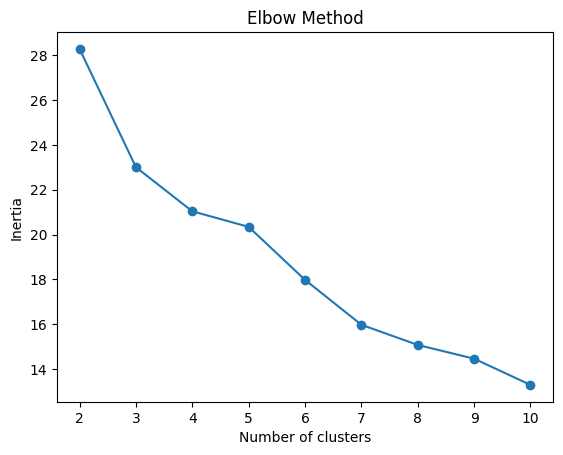

Silhouette Score for k=2: 0.1556
Silhouette Score for k=3: 0.2220
Silhouette Score for k=4: 0.1578
Silhouette Score for k=5: 0.1651
Silhouette Score for k=6: 0.1908
Silhouette Score for k=7: 0.2086
Silhouette Score for k=8: 0.1927
Silhouette Score for k=9: 0.1834
Silhouette Score for k=10: 0.2003


In [10]:
# Evaluate number of clusters using Elbow and Silhouette
inertias = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(category_embeddings)
    inertias.append(kmeans.inertia_)
plt.plot(range(2, 11), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(category_embeddings)
    score = silhouette_score(category_embeddings, labels)
    print(f"Silhouette Score for k={k}: {score:.4f}")

In [11]:
# k-means clustering
kmeans = KMeans(n_clusters=6, random_state=42)
df_cluster['cluster'] = kmeans.fit_predict(category_embeddings)

### Cluster quality assessment

In [12]:
print(df_cluster['cluster'].value_counts())

cluster
2    16
1    16
4    11
5     9
0     6
3     3
Name: count, dtype: int64


In [13]:
# Show sample rows for each cluster
num_clusters = 6
for i in range(num_clusters):
    print(f"\n🔸 Cluster {i} samples:")
    print(df_cluster[df_cluster['cluster'] == i]['cleaned_categories'].head(10).to_string(index=False))


🔸 Cluster 0 samples:
animals pet standard litter boxes litter boxes ...
garden garden oven mitts potholders kitchen din...
animals pet carriers totes hard sided carriers ...
garden garden kitchen storage organization kitc...
animals pet crate training crates kennels pet w...
animals pet crate training crates kennels pet d...

🔸 Cluster 1 samples:
tablets computers tablets networking tablets al...
toys games tablets learning toys toys tablets t...
tablets computers tablets all tablets tablets c...
tablets computers tablets networking tablets al...
tablets computers tablets networking android ta...
tablets computers tablets networking tablets al...
               tablets tablets all tablets tablets
tablets tablets all tablets tablets computers t...
tablets computers tablets networking tablets al...
tablets tablets tablets computers tablets kids ...

🔸 Cluster 2 samples:
health beauty health health household camcorder...
audio video tv video audio audio video dvd case...
stereos remote c

In [14]:
# Top words per cluster
print("\nTop Words per Cluster:")
for i in range(num_clusters):
    cluster_text = " ".join(df_cluster[df_cluster['cluster'] == i]['cleaned_categories'])
    word_freq = Counter(cluster_text.split())
    top_words = word_freq.most_common(10)
    print(f"\nCluster {i}: {[word for word, _ in top_words]}")


Top Words per Cluster:

Cluster 0: ['pet', 'kitchen', 'crates', 'dining', 'animals', 'top', 'products', 'garden', 'kennels', 'dog']

Cluster 1: ['tablets', 'computers', 'all', 'readers', 'networking', 'ebook', 'ipad', 'toys', 'kids', 'e']

Cluster 2: ['smart', 'speakers', 'audio', 'video', 'tv', 'health', 'consumer', 'echo', 'digital', 'batteries']

Cluster 3: ['tablets', 'readers', 'office', 'kindle', 'e', 'ebook', 'all', 'computers', 'college', 'walmart']

Cluster 4: ['readers', 'e', 'tablets', 'computers', 'reader', 'kindle', 'adapters', 'cables', 'ebook', 'book']

Cluster 5: ['computers', 'office', 'laptop', 'computer', 'bags', 'cases', 'file', 'stands', 'drive', 'expanding']


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


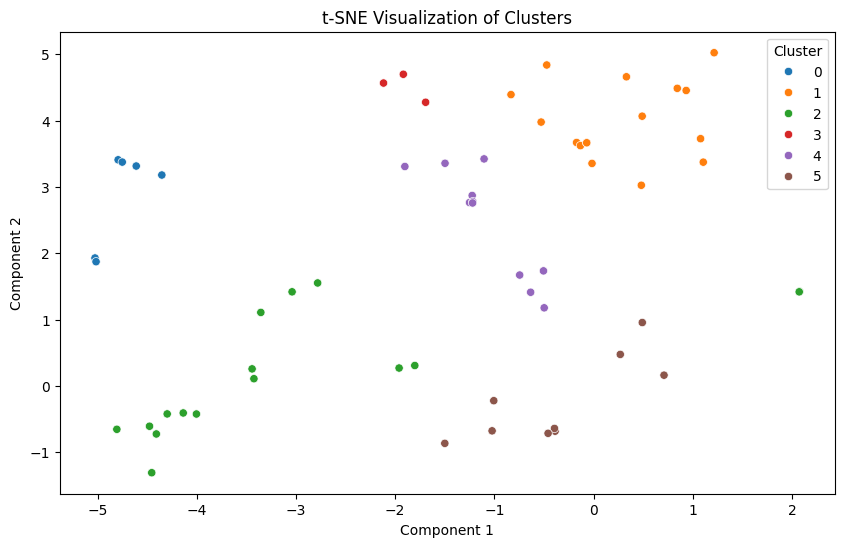

cluster
2    16
1    16
4    11
5     9
0     6
3     3
Name: count, dtype: int64


In [15]:
# Final: Visualize clusters using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_embeddings = tsne.fit_transform(category_embeddings)  # Apply t-SNE on original embeddings

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], hue=df_cluster['cluster'], palette='tab10')
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Cluster")
plt.show()

print(df_cluster['cluster'].value_counts())

In [16]:
# Merge similar clusters
merge_map = {0: 0, 1: 1, 2: 2, 3: 3, 4: 3, 5: 4}
df_cluster['merged_cluster'] = df_cluster['cluster'].map(merge_map)

## Analyze and label the resulting clusters

In [17]:
# Assign labels to merged clusters
label_mapping = {
    0: "Home & Pet Supplies",
    1: "Tablets & Kids Tech",
    2: "Smart Home & Audio Devices",
    3: "E-Readers",
    4: "Office & Laptop Accessories"
}
df_cluster['cluster_label'] = df_cluster['merged_cluster'].map(label_mapping)

In [18]:
df['cleaned_categories'] = df['cleaned_categories'].apply(filter_words)

In [19]:
df_cluster = df_cluster.drop_duplicates(subset='cleaned_categories')

In [20]:
# Merge labeled clusters back into original dataframe
df = df.merge(df_cluster[['cleaned_categories', 'cluster_label']], on='cleaned_categories', how='left')

In [21]:
# Create a new column that links each review to its assigned cluster label
df['review_cluster_label'] = df['cluster_label']

# Show random samples of reviews for each cluster label to verify the mapping
for label in df['review_cluster_label'].dropna().unique():
    print(f"\n🔹 Reviews under: {label}")
    print(df[df['review_cluster_label'] == label][['reviews.text']].dropna().sample(5, random_state=42).to_string(index=False))


🔹 Reviews under: Smart Home & Audio Devices
                                                                                        reviews.text
                                    Good product, fair price, fast shipping. What more could you ask
                                                                                great last long time
     A great inexpensive rout for your AA needs! Just as good as the expensive name brand batteries!
Good quality batteries at an affordable price. The batteries are long lasting with good performance.
                                                          Cheap, works, better quality then duracel.

🔹 Reviews under: Office & Laptop Accessories
                                                                                                                                                                                                                                                                                                               

In [22]:
print(df['reviews.text'].notna().sum())

28332


In [23]:
print(df['review_cluster_label'].value_counts(dropna=False))

review_cluster_label
Tablets & Kids Tech            14297
Smart Home & Audio Devices     12726
E-Readers                       1205
Office & Laptop Accessories       96
Home & Pet Supplies                8
Name: count, dtype: int64


In [24]:
print(df.shape)

(28332, 28)


# Task 3. Summarize reviews using generative AI

In [40]:
pip install --upgrade openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 643.9/643.9 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.70.0
    Uninstalling openai-1.70.0:
      Successfully uninstalled openai-1.70.0


In [57]:
!pip install markdown

In [4]:
import openai
import os
import pandas as pd
from collections import defaultdict
import markdown

In [5]:
from google.colab import userdata
openai.api_key = userdata.get("OPENAI_API")

In [52]:
# Clean reviews
df_reviews = df[['reviews.text', 'cluster_label', 'imageURLs']].dropna(subset=['reviews.text', 'cluster_label'])
df_reviews['reviews.text'] = df_reviews['reviews.text'].str.strip().str.replace(r'\s+', ' ', regex=True)

# Group by category
grouped_reviews = df_reviews.groupby('cluster_label')['reviews.text'].apply(list).to_dict()
category_summaries = {}

In [53]:
for category, reviews in grouped_reviews.items():
    sample_reviews = reviews[:30] # Take only 30 reviews to adjust the size
    reviews_text = "\n".join(f"- {r}" for r in sample_reviews)

    user_prompt = f"""
Category: {category}

You are a professional blog writer summarizing customer reviews.

Write a blog-style article with the following structure:

1. **Title** — A catchy and relevant blog title
2. **Introduction** — Brief overview of the category and how the products were chosen
3. **Top 3 Recommended Products** — Each with the following format:

Product {1}:
- **Name:** (if mentioned in reviews, otherwise label as Product A/B/C)
- **What makes it stand out:** Summary of positive points
- **Top complaints:** List of common user complaints

(Repeat for Product 2 and 3)

4. **Key Differences** — Compare the 3 products clearly in 2–3 bullet points.

5. **Worst Product to Avoid**
- **Why it's the worst:** Summarize what users complained about

6. **Conclusion** — Give a short helpful wrap-up for buyers.

Use clear markdown formatting and a friendly, informative tone.

Customer Reviews:
{reviews_text}
    """

    try:
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant that writes product recommendation blog posts based on real customer reviews."},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0.7,
            max_tokens=1000
        )

        summary = response.choices[0].message.content
        category_summaries[category] = summary
        print(f"\n🔹 Article for category: {category}\n{summary}")

    except Exception as e:
        print(f"❌ Error generating article for category {category}: {str(e)}")



🔹 Article for category: E-Readers
# Blog Title: The Ultimate E-Reader Charger Review: Top Picks and Tips

## Introduction
E-readers are a convenient way to carry around your favorite books and documents without the bulk of physical copies. Choosing the right charger for your e-reader can make a big difference in ensuring you always have enough battery life for your reading needs. Based on real customer reviews, we have compiled a list of the top e-reader chargers to help you make an informed decision.

## Top 3 Recommended Products

### Product 1:
- **Name:** Kindle Fast Charger
- **What makes it stand out:** Charges Kindle devices quickly and efficiently
- **Top complaints:** Some users found that it did not charge as fast as expected, and others wished it came with a longer cord.

### Product 2:
- **Name:** Kindle Wall Charger
- **What makes it stand out:** Works well with Kindle Paperwhite and charges devices effectively
- **Top complaints:** Users were disappointed that it did not

In [49]:
# Export results
summary_df = pd.DataFrame([
    {"category": label, "summary": summary}
    for label, summary in category_summaries.items()
])
summary_df.to_excel("refined_product_summaries.xlsx", index=False)
print("✅ Exported successfully.")

✅ Exported successfully.


In [77]:
import os
from pathlib import Path
from bs4 import BeautifulSoup

# 1. Create a folder for HTML articles
output_dir = Path("html_articles")
output_dir.mkdir(exist_ok=True)

# 2. Get an image for each category.
category_images = {}

for category in grouped_reviews.keys():
    category_reviews = df_reviews[df_reviews['cluster_label'] == category]
    image_col = category_reviews['imageURLs'].dropna()

    if not image_col.empty:
        first_link = image_col.iloc[0].split(',')[0]

        # ✅ Custom replacement if the image is bad or small
        if category == 'Office & Laptop Accessories':
            category_images[category] = "https://images.unsplash.com/photo-1593642634367-d91a135587b5?auto=format&fit=crop&w=800&q=80"
        else:
            category_images[category] = first_link
    else:
        category_images[category] = None


# 3. Create HTML files
for category, summary in category_summaries.items():
    image_url = category_images.get(category)
    # Process newlines before inserting them into the f-string.
    summary_html = markdown.markdown(summary)

    filename = output_dir / f"{category.replace('&', 'and').replace(' ', '_')}.html"

    html = f"""
    <html>
    <head>
        <title>{category} - Product Summary</title>
        <meta charset="UTF-8">
        <style>
            body {{
                font-family: Arial, sans-serif;
                margin: 40px;
                line-height: 1.6;
                background-color: #f9f9f9;
                color: #333;
            }}
            img {{
                max-width: 300px;
                display: block;
                margin-bottom: 20px;
            }}
            .container {{
                background: white;
                padding: 30px;
                border-radius: 12px;
                box-shadow: 0 2px 6px rgba(0,0,0,0.1);
            }}
        </style>
    </head>
    <body>
        <div class="container">
            <h1>{category} - Product Recommendation</h1>
            {'<img src="' + image_url + '" alt="Product image">' if image_url else ''}
            <div>
                {summary_html}
            </div>
        </div>
    </body>
    </html>
    """

    with open(filename, "w", encoding="utf-8") as f:
        f.write(html)

print(f"✅ Exported HTML files to: {output_dir.absolute()}")

✅ Exported HTML files to: /content/html_articles


In [82]:
!zip -r html_articles.zip html_articles

updating: html_articles/ (stored 0%)
updating: html_articles/Home_and_Pet_Supplies.html (deflated 59%)
updating: html_articles/Office_and_Laptop_Accessories.html (deflated 58%)
updating: html_articles/E-Readers.html (deflated 61%)
updating: html_articles/Smart_Home_and_Audio_Devices.html (deflated 60%)
updating: html_articles/Tablets_and_Kids_Tech.html (deflated 60%)
  adding: html_articles/index.html (deflated 59%)


In [83]:
from google.colab import files
files.download("html_articles.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [80]:
from pathlib import Path

# Path to the folder containing all the generated HTML articles
articles_dir = Path("html_articles")
index_path = articles_dir / "index.html"

# HTML header with basic styling
html_header = """
<html>
<head>
    <title>Product Recommendation Blog</title>
    <meta charset="UTF-8">
    <style>
        body {
            font-family: Arial, sans-serif;
            padding: 40px;
            background-color: #f8f8f8;
        }
        h1 {
            color: #333;
        }
        ul {
            list-style-type: none;
            padding: 0;
        }
        li {
            margin: 12px 0;
        }
        a {
            text-decoration: none;
            color: #0066cc;
            font-size: 18px;
        }
        a:hover {
            text-decoration: underline;
        }
    </style>
</head>
<body>
    <h1>📝 Product Recommendation Articles</h1>
    <ul>
"""

# HTML footer
html_footer = """
    </ul>
</body>
</html>
"""

# Generate the list of links for each article
links_html = ""
for file in sorted(articles_dir.glob("*.html")):
    if file.name == "index.html":
        continue  # Skip the index file itself
    title = file.stem.replace("_", " ").replace("and", "&")
    links_html += f'        <li><a href="{file.name}">📌 {title}</a></li>\n'

# Write the index.html file
with open(index_path, "w", encoding="utf-8") as f:
    f.write(html_header + links_html + html_footer)

print(f"✅ index.html created at: {index_path.absolute()}")

✅ index.html created at: /content/html_articles/index.html


In [81]:
from google.colab import files
files.download("html_articles/index.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>